<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [ ]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter
!pip install -q ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Install Essential Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, global_add_pool


In [ ]:
def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Accuracy','Train Loss','Test Accuracy','Test Loss'])
    plt.grid(True)
    
    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

## Read the Dataset

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader

dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv') 

split_idx = dataset.get_idx_split() 
train_data_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
valiation_data_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=True)
test_data_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=True)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 79691.41it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 29803.56it/s]


Saving...


Done!


In [5]:
!unzip /content/ml-1m.zip

Archive:  /content/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [1]:
import numpy as np
import pandas as pd

movies_df = pd.read_csv('/content/ml-1m/movies.dat', sep='::', engine='python', encoding="latin-1",
                        names=['MovieID','Title','Genres'])
rating_df = pd.read_csv('/content/ml-1m/ratings.dat', sep='::', engine='python', encoding="latin-1",
                        names=['UserID','MovieID','Rating','Timestamp'])
users_df = pd.read_csv('/content/ml-1m/users.dat', sep='::', engine='python', encoding="latin-1",
                       names=['UserID','Gender','Age','Occupation','Zipcode'])
movies_df.shape, rating_df.shape, users_df.shape

((3883, 3), (1000209, 4), (6040, 5))

In [2]:
geners = np.array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
                   'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'], dtype=str)

values = list(range(0, len(geners)))
dictionary = dict(zip(geners, values))

def extract_geners(text, sep='|'):
  return text.split(sep)

def geners2vector(df_geners, maper):
  result = np.zeros((len(df_geners),len(dictionary)), dtype='int8')
  for index, text in enumerate(df_geners):
    geners = extract_geners(text)
    for gener in geners:
      result[index][maper.get(gener)] = 1
  
  return result

geners2vector(movies_df['Genres'], dictionary)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int8)

In [3]:
def year_extractor(text):
  return text[text.find('(')+1:text.find(')')]

movies_df['year'] = movies_df['Title'].apply(year_extractor)

In [4]:
def calculate_average_rating(rating_df, movies_df, Movie_id_col='MovieID', rating_col='Rating'):
  
  rating_avg = rating_df.groupby(Movie_id_col).mean()[rating_col].round(4).to_dict()
  result = [] 
  for id in movies_df[Movie_id_col]:
    result.append(rating_avg.get(id, 0))
  movies_df['averge_rating'] = result
  return movies_df

movies_df = calculate_average_rating(rating_df, movies_df)
movies_df

,MovieID,Title,Genres,year,averge_rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,4.1468
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,3.2011
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.0167
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,2.7294
4,5,Father of the Bride Part II (1995),Comedy,1995,3.0068
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000,3.6357
3879,3949,Requiem for a Dream (2000),Drama,2000,4.1151
3880,3950,Tigerland (2000),Drama,2000,3.6667
3881,3951,Two Family House (2000),Drama,2000,3.9000


In [5]:
users_df['Gender'] = pd.get_dummies(users_df['Gender'], drop_first=True)

Occupation_mapper = { 0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                     4: "college/grad student",5: "customer service", 6: "doctor/health care",
                     7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
                     11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
                     15: "scientist", 16: "self-employed", 17: "technician/engineer",
                     18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

def code2Occupation(occupation_col, mapper):
  return occupation_col.map(mapper)

users_df['Occupation'] = code2Occupation(users_df['Occupation'], Occupation_mapper)
users_df

,UserID,Gender,Age,Occupation,Zipcode
0,1,0,1,K-12 student,48067
1,2,1,56,self-employed,70072
2,3,1,25,scientist,55117
3,4,1,45,executive/managerial,02460
4,5,1,25,writer,55455
...,...,...,...,...,...
6035,6036,0,25,scientist,32603
6036,6037,0,45,academic/educator,76006
6037,6038,0,56,academic/educator,14706
6038,6039,0,45,other,01060


In [6]:
from datetime import datetime

def Timestamp2Date(timestamp):
  return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

rating_df['Timestamp'] = rating_df['Timestamp'].apply(Timestamp2Date)
rating_df.sort_values(by=['Timestamp'], inplace=True)
rating_df.reset_index(drop=True, inplace=True)

In [7]:
rating_df

,UserID,MovieID,Rating,Timestamp
0,6040,858,4,2000-04-25 23:05:32
1,6040,2384,4,2000-04-25 23:05:54
2,6040,593,5,2000-04-25 23:05:54
3,6040,1961,4,2000-04-25 23:06:17
4,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
1000204,4958,2399,1,2003-02-28 17:45:38
1000205,4958,1407,5,2003-02-28 17:47:23
1000206,4958,3264,4,2003-02-28 17:49:08
1000207,4958,2634,3,2003-02-28 17:49:08


In [ ]:
for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Streaming output truncated to the last 5000 lines.
Batch 30:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1660], edge_attr=[1660, 3], x=[770, 9], y=[32, 1], num_nodes=770, batch=[770], ptr=[33])

Batch 31:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1804], edge_attr=[1804, 3], x=[840, 9], y=[32, 1], num_nodes=840, batch=[840], ptr=[33])

Batch 32:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1920], edge_attr=[1920, 3], x=[901, 9], y=[32, 1], num_nodes=901, batch=[901], ptr=[33])

Batch 33:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1444], edge_attr=[1444, 3], x=[677, 9], y=[32, 1], num_nodes=677, batch=[677], ptr=[33])

Batch 34:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1682], edge_attr=[1682, 3], x=[778, 9], y=[32, 1], num_nodes=778, batch=[778], ptr=[33])

Batch 35:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1702], edge_attr=[1702, 3], x=[798, 9

## Split the Dataset

In [ ]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [ ]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.8)
print(f'Number of graphs in the Train Dataset: {len(train_dataset)}')
print(f'Number of graphs in the Test Dataset: {len(test_dataset)}')

Number of graphs in the Train Dataset: 32901
Number of graphs in the Test Dataset: 8226


## Batch Generator

In [ ]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [ ]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3566], edge_attr=[3566, 3], x=[1642, 9], y=[64, 1], num_nodes=1642, batch=[1642], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3630], edge_attr=[3630, 3], x=[1695, 9], y=[64, 1], num_nodes=1695, batch=[1695], ptr=[65])

Batch 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3446], edge_attr=[3446, 3], x=[1603, 9], y=[64, 1], num_nodes=1603, batch=[1603], ptr=[65])

Batch 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3584], edge_attr=[3584, 3], x=[1670, 9], y=[64, 1], num_nodes=1670, batch=[1670], ptr=[65])

Batch 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3494], edge_attr=[3494, 3], x=[1622, 9], y=[64, 1], num_nodes=1622, batch=[1622], ptr=[65])

Batch 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3522], edge_attr=[3522, 3], x=[1629, 9], y=[64, 1], num_nodes=1629, batch=[1629

## Single sample of Batch 3

In [ ]:
data[0]

Data(edge_index=[2, 46], edge_attr=[46, 3], x=[22, 9], y=[1, 1], num_nodes=22)

In [ ]:
class GCN_Add_Pooling(torch.nn.Module):
    
    def __init__(self, hidden_channels, aggregation):
        super(GCN_Add_Pooling, self).__init__()
        torch.manual_seed(12345)
        if type(aggregation) != list:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)
        else:
          i=1
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv2 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv3 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv4 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          self.lin = Linear(hidden_channels*(len(aggregation)**(i+1)), dataset.num_classes)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [ ]:
class Graph_Sage(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Sage, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)


        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Graph_Conv(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        
        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Graph_Conv3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv3, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        
        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.006,
        best_results=[0, 0, 0],
        ):
      
      super().__init__()
      self.model = model
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.best_results = best_results
    
    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss = self.criterion(out, data.y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def evaluate(self, data_loader):
        self.model.eval()

        correct, loss = 0, 0
        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch).float()
            loss += self.criterion(out, data.y)  
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
        return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

    def train_and_evaluate(self, train_data_loader, test_data_loader, n_epochs=200):
      
      list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)
          
          train_accuracy, train_loss = self.evaluate(train_data_loader)
          list_train_acc.append(train_accuracy)
          list_train_loss.append(float(train_loss.detach()))
          
          test_accuracy, test_loss = self.evaluate(test_data_loader)
          if self.best_results[-1] + self.best_results[1] < test_accuracy + train_accuracy :
            self.best_results[0], self.best_results[1], self.best_results[-1] = epoch, train_accuracy ,test_accuracy

          list_test_acc.append(test_accuracy)
          list_test_loss.append(float(test_loss.detach()))

          print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
      
      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train Accuracy: {self.best_results[1]:.4f}, Test Accuracy: {self.best_results[-1]:.4f}')
      return list_train_acc, list_train_loss, list_test_acc, list_test_loss
      

### Aggregation Function = add

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='add')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_add = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_add.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...


RuntimeError: ignored

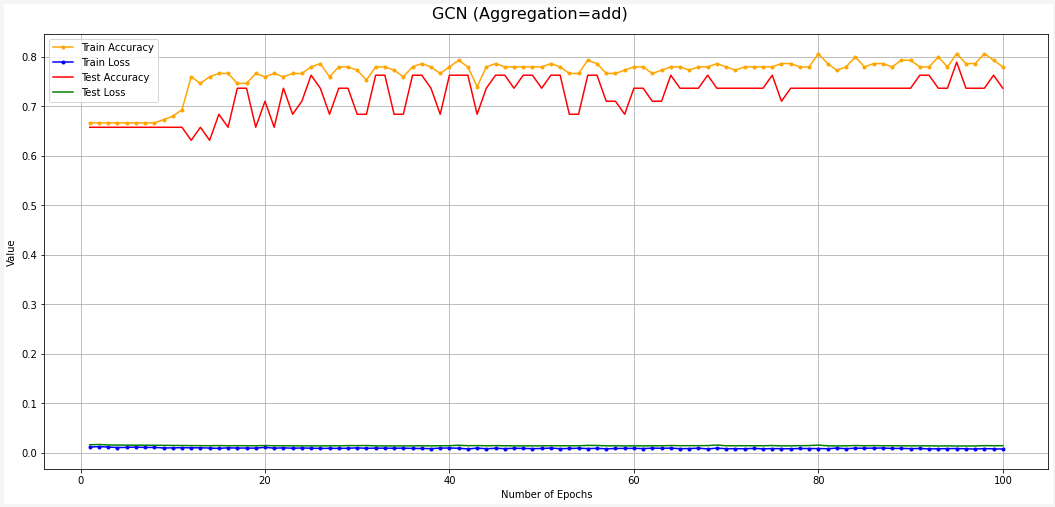

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=add)')

### Aggregation Function = Max

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='max')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_max = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_max.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0118, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0121, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0163
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 006, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0117, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 009, Train Accuracy: 0.6667, Train Loss: 0.0107, Test Accuracy: 0.6579, Test Loss: 0.0158
Epoch: 010, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.015

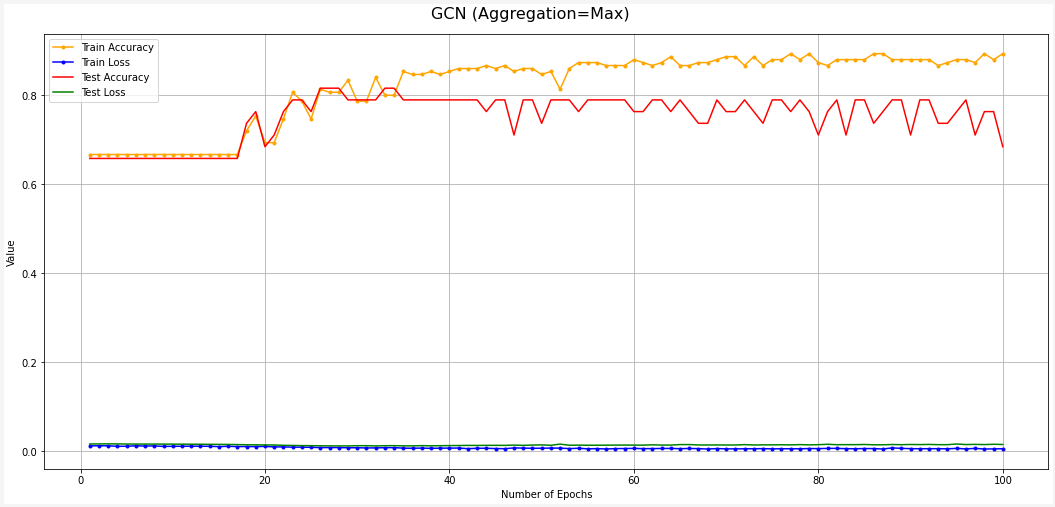

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=Max)')

### Aggregation Function = Min

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='mean')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_mean = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_mean.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0119, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0162
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0164
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.0161
Epoch: 006, Train Accuracy: 0.6667, Train Loss: 0.0120, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0118, Test Accuracy: 0.6579, Test Loss: 0.0160
Epoch: 009, Train Accuracy: 0.6667, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0159
Epoch: 010, Train Accuracy: 0.6667, Train Loss: 0.0110, Test Accuracy: 0.6579, Test Loss: 0.015

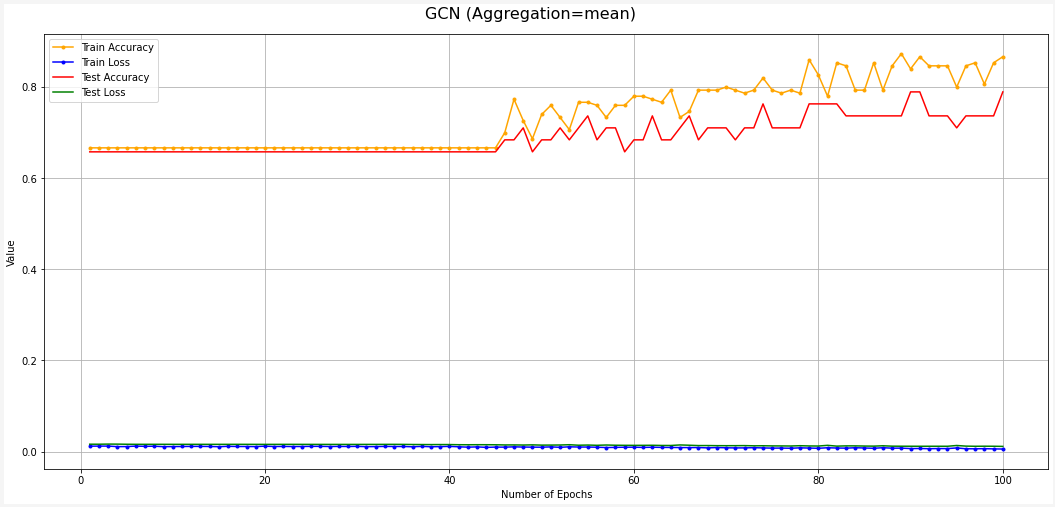

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=mean)')

### Aggregation Function = [Add, Max, Min]

In [ ]:
model = GCN_Add_Pooling(hidden_channels=8, aggregation=['add','mean','max'])
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 24)
  (conv2): GCNConv(72, 72)
  (conv3): GCNConv(216, 216)
  (conv4): GCNConv(648, 648)
  (lin): Linear(in_features=1944, out_features=2, bias=True)
)


In [ ]:
evaluate_GCN_all = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_all.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0109, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 002, Train Accuracy: 0.6667, Train Loss: 0.0112, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0104, Test Accuracy: 0.6579, Test Loss: 0.0147
Epoch: 004, Train Accuracy: 0.6867, Train Loss: 0.0100, Test Accuracy: 0.6842, Test Loss: 0.0141
Epoch: 005, Train Accuracy: 0.7667, Train Loss: 0.0091, Test Accuracy: 0.7368, Test Loss: 0.0134
Epoch: 006, Train Accuracy: 0.7800, Train Loss: 0.0088, Test Accuracy: 0.7105, Test Loss: 0.0136
Epoch: 007, Train Accuracy: 0.7733, Train Loss: 0.0082, Test Accuracy: 0.7368, Test Loss: 0.0143
Epoch: 008, Train Accuracy: 0.7733, Train Loss: 0.0082, Test Accuracy: 0.7105, Test Loss: 0.0140
Epoch: 009, Train Accuracy: 0.8133, Train Loss: 0.0073, Test Accuracy: 0.7368, Test Loss: 0.0138
Epoch: 010, Train Accuracy: 0.7733, Train Loss: 0.0096, Test Accuracy: 0.7368, Test Loss: 0.014

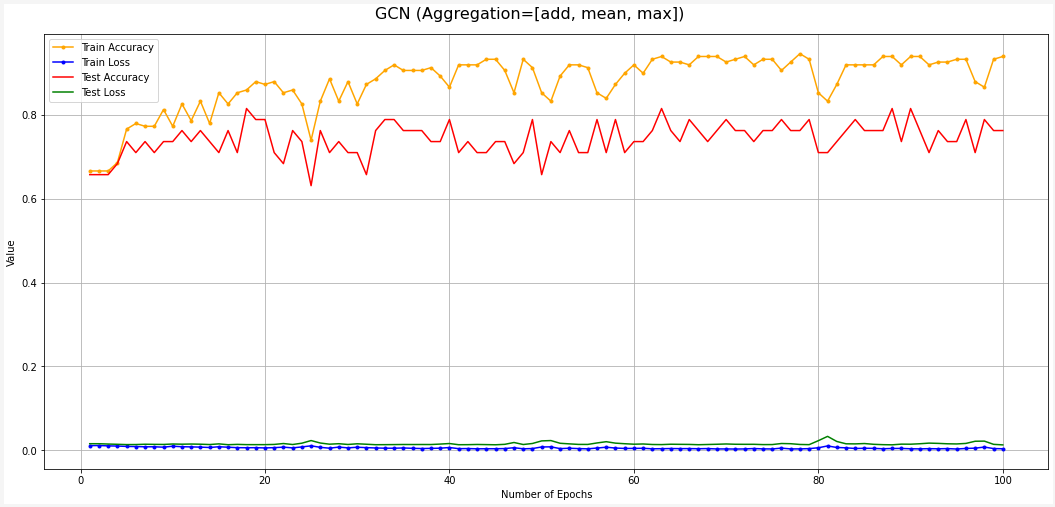

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=[add, mean, max])')

### GraphSage

In [ ]:
model = Graph_Sage(hidden_channels=64)
print(model)

Graph_Sage(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphSage = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphSage.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0123, Test Accuracy: 0.6579, Test Loss: 0.0175
Epoch: 002, Train Accuracy: 0.7000, Train Loss: 0.0122, Test Accuracy: 0.6579, Test Loss: 0.0165
Epoch: 003, Train Accuracy: 0.6667, Train Loss: 0.0146, Test Accuracy: 0.6579, Test Loss: 0.0206
Epoch: 004, Train Accuracy: 0.6667, Train Loss: 0.0129, Test Accuracy: 0.6579, Test Loss: 0.0193
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0111, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0155
Epoch: 007, Train Accuracy: 0.6667, Train Loss: 0.0108, Test Accuracy: 0.6579, Test Loss: 0.0158
Epoch: 008, Train Accuracy: 0.6667, Train Loss: 0.0130, Test Accuracy: 0.6579, Test Loss: 0.0169
Epoch: 009, Train Accuracy: 0.6733, Train Loss: 0.0102, Test Accuracy: 0.6579, Test Loss: 0.0150
Epoch: 010, Train Accuracy: 0.7267, Train Loss: 0.0105, Test Accuracy: 0.6842, Test Loss: 0.014

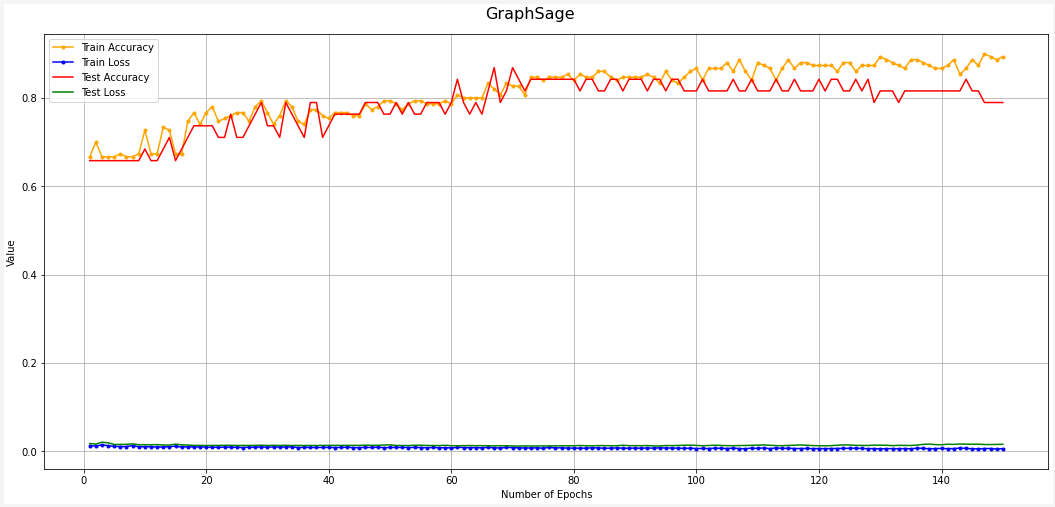

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphSage')

### GraphConv

In [ ]:
model = Graph_Conv(hidden_channels=64)
print(model)

Graph_Conv(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (conv4): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphConv = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphConv.train_and_evaluate(train_data_loader, test_data_loader,  n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6667, Train Loss: 0.0309, Test Accuracy: 0.6579, Test Loss: 0.0453
Epoch: 002, Train Accuracy: 0.7133, Train Loss: 0.0099, Test Accuracy: 0.6316, Test Loss: 0.0144
Epoch: 003, Train Accuracy: 0.6733, Train Loss: 0.0169, Test Accuracy: 0.6579, Test Loss: 0.0250
Epoch: 004, Train Accuracy: 0.8000, Train Loss: 0.0101, Test Accuracy: 0.7105, Test Loss: 0.0153
Epoch: 005, Train Accuracy: 0.6667, Train Loss: 0.0115, Test Accuracy: 0.6316, Test Loss: 0.0172
Epoch: 006, Train Accuracy: 0.6733, Train Loss: 0.0148, Test Accuracy: 0.6579, Test Loss: 0.0242
Epoch: 007, Train Accuracy: 0.7933, Train Loss: 0.0075, Test Accuracy: 0.7105, Test Loss: 0.0127
Epoch: 008, Train Accuracy: 0.7933, Train Loss: 0.0099, Test Accuracy: 0.7105, Test Loss: 0.0166
Epoch: 009, Train Accuracy: 0.8200, Train Loss: 0.0078, Test Accuracy: 0.7368, Test Loss: 0.0122
Epoch: 010, Train Accuracy: 0.7600, Train Loss: 0.0082, Test Accuracy: 0.6842, Test Loss: 0.012

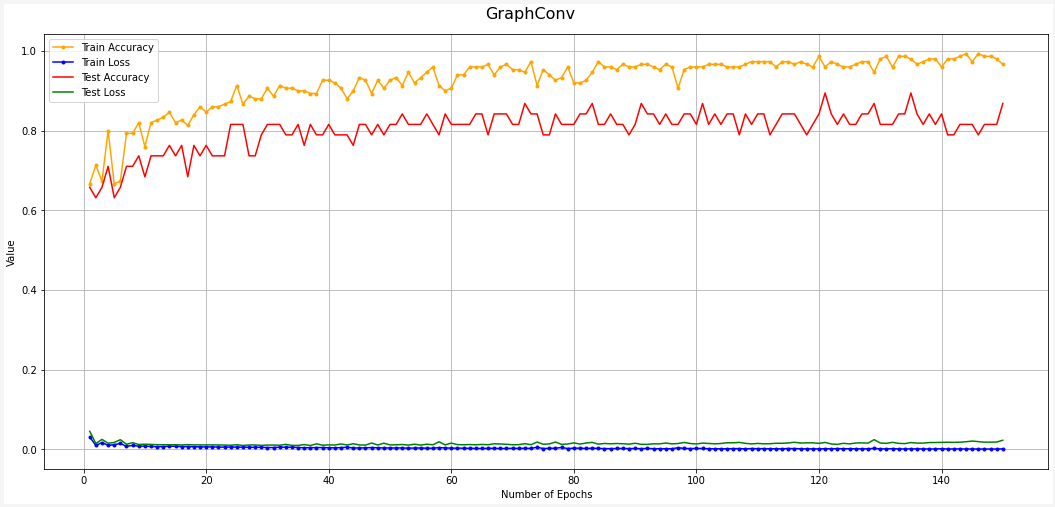

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphConv')

In [ ]:
model = Graph_Conv3(hidden_channels=64)
print(model)

Graph_Conv3(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
evaluate_GraphConv3 = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphConv3.train_and_evaluate(train_data_loader, test_data_loader,  n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.7400, Train Loss: 0.0082, Test Accuracy: 0.6579, Test Loss: 0.0133
Epoch: 002, Train Accuracy: 0.6733, Train Loss: 0.0172, Test Accuracy: 0.6579, Test Loss: 0.0278
Epoch: 003, Train Accuracy: 0.7333, Train Loss: 0.0143, Test Accuracy: 0.6842, Test Loss: 0.0196
Epoch: 004, Train Accuracy: 0.7533, Train Loss: 0.0113, Test Accuracy: 0.6316, Test Loss: 0.0186
Epoch: 005, Train Accuracy: 0.6933, Train Loss: 0.0133, Test Accuracy: 0.6579, Test Loss: 0.0228
Epoch: 006, Train Accuracy: 0.7667, Train Loss: 0.0085, Test Accuracy: 0.7368, Test Loss: 0.0140
Epoch: 007, Train Accuracy: 0.7667, Train Loss: 0.0085, Test Accuracy: 0.7368, Test Loss: 0.0138
Epoch: 008, Train Accuracy: 0.7733, Train Loss: 0.0084, Test Accuracy: 0.6842, Test Loss: 0.0129
Epoch: 009, Train Accuracy: 0.7933, Train Loss: 0.0083, Test Accuracy: 0.6842, Test Loss: 0.0133
Epoch: 010, Train Accuracy: 0.7933, Train Loss: 0.0080, Test Accuracy: 0.6842, Test Loss: 0.012

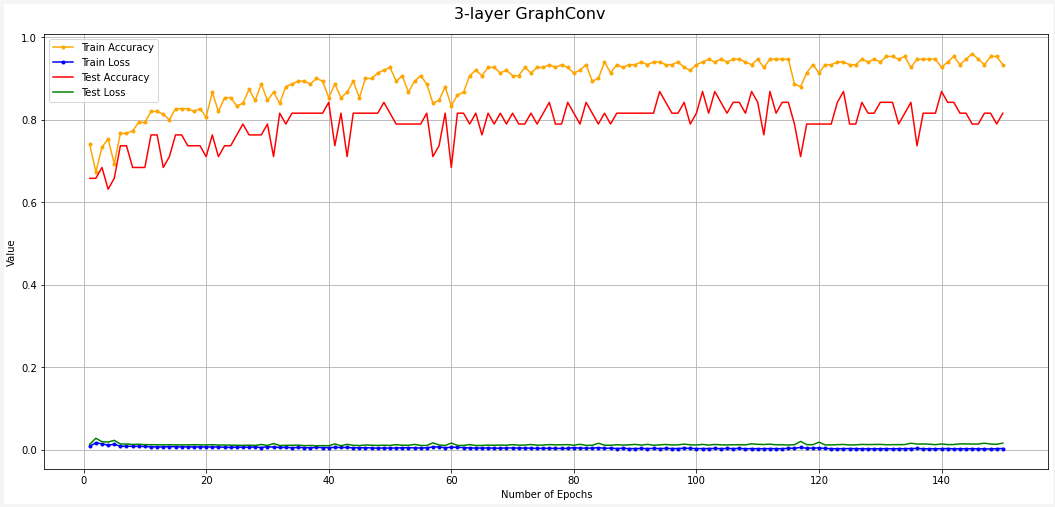

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='3-layer GraphConv')

In [ ]:
import pandas as pd

conclusion = pd.DataFrame([
    ['4-layer GCN (Agg=add)' ,0.8067, 0.0084, 0.7895, 0.0135, 95],
    ['4-layer GCN (Agg=max)' ,0.88, 0.0058, 0.7895, 0.0139, 69],
    ['4-layer GCN (Agg=mean)' ,0.8667, 0.0068, 0.7895, 0.0117, 91],
    ['4-layer GCN (Agg=[ add, max, mean ])' ,0.94, 0.0037, 0.8158, 0.0134, 63],
    ['4-layer GraphSage (Agg=defualt)' ,0.8733, 0.0063, 0.8421, 0.0125, 120],
    ['4-layer GraphConv (Agg=defualt)' ,0.98, 0.0012, 0.8947, 0.0170, 135],
    ['3-layer GraphConv (Agg=defualt)' ,0.9467, 0.0028, 0.8684, 0.0137, 112]
    ],
    columns=["Model Details","Train Accuracy", "Train loss", "Test Accuracy", "Test loss", 'Epoch with best result'])

conclusion = conclusion.set_index('Model Details')
conclusion.style.background_gradient(cmap="YlOrRd")

,Train Accuracy,Train loss,Test Accuracy,Test loss,Epoch with best result
Model Details,,,,,
4-layer GCN (Agg=add),0.806700,0.008400,0.789500,0.013500,95
4-layer GCN (Agg=max),0.880000,0.005800,0.789500,0.013900,69
4-layer GCN (Agg=mean),0.866700,0.006800,0.789500,0.011700,91
"4-layer GCN (Agg=[ add, max, mean ])",0.940000,0.003700,0.815800,0.013400,63
4-layer GraphSage (Agg=defualt),0.873300,0.006300,0.842100,0.012500,120
4-layer GraphConv (Agg=defualt),0.980000,0.001200,0.894700,0.017000,135
3-layer GraphConv (Agg=defualt),0.946700,0.002800,0.868400,0.013700,112
